In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import random
from sklearn import model_selection

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation, GlobalMaxPooling2D,BatchNormalization
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from itertools import chain, repeat, cycle


import os
import shutil
%matplotlib inline

Using TensorFlow backend.


In [2]:
import re
import collections


DATA_DIR = "./rename"
TRAIN_DIR = "./train"
VAL_DIR = "./val"
validation_percentage = 10



In [3]:
NUM_TRAIN_EXAMPLES = 0
NUM_VAL_EXAMPLES = 0

if not os.path.exists(TRAIN_DIR) or  not os.path.exists(VAL_DIR):
    data = glob.glob(DATA_DIR + "/*.jpg")
    print("creating data directories for training and validation")
    train, val = model_selection.train_test_split(data, test_size=0.1)
    os.makedirs(TRAIN_DIR)
    os.makedirs(VAL_DIR)

    for e in train:
        shutil.copy(e, TRAIN_DIR + "/" + e.split("/")[-1] )
    for e in val:
        shutil.copy(e, VAL_DIR + "/" + e.split("/")[-1] )
else:
    print("directories already exist")
    NUM_TRAIN_EXAMPLES = len(glob.glob(TRAIN_DIR+"/*.jpg"))
    print("Train:", NUM_TRAIN_EXAMPLES )
    NUM_VAL_EXAMPLES = len(glob.glob(VAL_DIR+"/*.jpg"))
    print("Validation:",NUM_VAL_EXAMPLES )

directories already exist
Train: 145134
Validation: 16126


In [4]:
vgg_model = VGG16(weights='imagenet', include_top=False, pooling='avg')


In [6]:
img_width, img_height = 224, 224
batch_size = 32

top_layers_checkpoint_path = './model/VGG16/cp.top.best.hdf5'
fine_tuned_checkpoint_path = './model/VGG16/cp.fine_tuned.best.hdf5'
new_extended_weights = './model/VGG16/final_weights.hdf5'

x = vgg_model.output
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
prediction = Dense(264, activation='sigmoid')(x)

model = Model(inputs=vgg_model.input, outputs=prediction)

if os.path.exists(top_layers_checkpoint_path):
    model.load_weights(top_layers_checkpoint_path)
    print ("Checkpoint '" + top_layers_checkpoint_path + "' loaded.")

"""
Freeze all inception layers
"""
for layer in vgg_model.layers:
    layer.trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
import pandas as pd
mvc_label = pd.read_csv( './mvc_label.csv', index_col='filename')

In [8]:
def grouper(n, iterable, padvalue=None):
    g = cycle(zip(*[chain(iterable, repeat(padvalue, n-1))]*n))
    for batch in g:
        yield list(filter(None, batch))
 
 
def multilabel_flow(path_to_data, idg, bs=256, target_size=(256,256), train_or_valid='train', shuffle=False):
    gen = idg.flow_from_directory(path_to_data, batch_size=bs, target_size=target_size, classes=[train_or_valid],shuffle=shuffle)
    names_generator = grouper(bs, gen.filenames)
    #print(gen.filenames)
    for (X_batch, _), names in zip(gen, names_generator):
    #    print(names)
        labels = [ mvc_label.loc[n.split('/')[-1]] for n in names ]
        targets = np.array(labels)
        yield X_batch, targets

In [9]:
train_gen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.3,
    channel_shift_range=0.3,
    horizontal_flip=True)

test_gen = image.ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = multilabel_flow(
                    './',
                    train_gen,
                    bs=batch_size,
                    target_size=(img_height, img_width),
                    train_or_valid='train',shuffle=True)

validation_generator = multilabel_flow(
                    './',
                    test_gen,
                    bs=batch_size,
                    target_size=(img_height, img_width),
                    train_or_valid='val', shuffle=True)

Found 145134 images belonging to 1 classes.


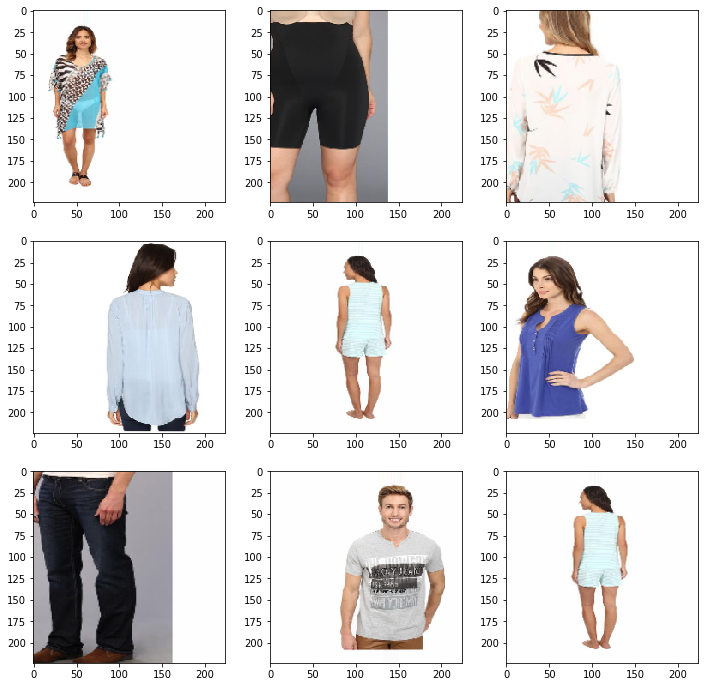

In [11]:
samples = next(train_generator)
fig, draws = plt.subplots(3,3, figsize=(12,12))
draws = draws.reshape(-1)
for i in range(9):
    draws[i].imshow(samples[0][random.randint(0, 23)])

In [12]:
tb = TensorBoard(log_dir='./logs', write_graph=True)
mc_top = ModelCheckpoint(top_layers_checkpoint_path,
                         monitor='val_acc', verbose=0,
                         save_best_only=True,
                         save_weights_only=False,
                         mode='auto', period=1)
top_epochs = 5

model.fit_generator(train_generator, steps_per_epoch=NUM_TRAIN_EXAMPLES//batch_size,
         nb_epoch=top_epochs, validation_data=validation_generator,
         validation_steps=NUM_VAL_EXAMPLES//batch_size,
         callbacks=[mc_top, tb], use_multiprocessing=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=4535, use_multiprocessing=True, epochs=5, validation_steps=503, callbacks=[<keras.ca..., validation_data=<generator...)`
  if sys.path[0] == '':


Found 16126 images belonging to 1 classes.
Epoch 1/5
 324/4535 [=>............................] - ETA: 45:45 - loss: 0.1723 - acc: 0.9312

Process Process-4:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/utils/data_utils.py", line 677, in _data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-8-1719dff96640>", line 11, in multilabel_flow
    for (X_batch, _), names in zip(gen, names_generator):
  File "/usr/local/lib/python3.5/dist-packages/keras_preprocessing/image.py", line 1331, in __next__
    return self.next(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras_preprocessing/image.py", line 1819, in next
    return self._get_batches_of_transformed_samples(index_array)
  File "/usr/local/lib/python3.5/dist-packages/keras_preprocessing/image.py", line 1779, in _get_batches_of_transformed_samples
    x = self.image_data

KeyboardInterrupt: 